In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
import os
import pickle
import importlib
import detect_bursts
importlib.reload(detect_bursts)
import copy
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,balanced_accuracy_score
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_predict
from sklearn.tree import DecisionTreeClassifier
#XGBOOST
from xgboost import XGBClassifier
import xgboost
from pygam import GAM, s, f, LogisticGAM
from collections import defaultdict
from sklearn import tree

import optuna

Load Unlabeled Data

In [3]:
def convertIntoFloatList(str):
    #preprocess data extracted
    #remove the "[" and "]" characters
    str = str[1:-1]
    if str == '':
        return None
    return np.array(str.split(','),dtype = float)

def readData(frame,mothName):
    #convert dataframe rows into an entire list
    tp = []
    nameArr = []
    for ind in frame.index:
        inc = convertIntoFloatList(frame[ind])
        if inc is not None:
            tp.append(inc)
            nameArr.append(mothName)
    return tp,nameArr

#load xlsx data, extract column with largest pre_stim
def argMaxPreStim(mothNum):

    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/timestamps_{mothNum}.csv'

    df = pd.read_csv(loadPath,header=0)

    argMaxColName = df.columns[np.argmax(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMaxColName}##########")
    return argMaxColName

#load xlsx data, extract column with smallest pre_stim
def argMinPreStim(mothNum):

    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/ALdata/timestamps_{mothNum}.csv'

    df = pd.read_csv(loadPath,header=0)

    argMinColName = df.columns[np.argmin(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMinColName}##########")
    return argMinColName

#load csv data, extract timestamps
def loadData(mothNum):
    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/ALdata/{mothNum}_spontaneous.csv'

    df = pd.read_csv(loadPath, header = 0)
    
    
    #take samples with stimuli giving largest pre_stim value in first row
    # stimuli = argMinPreStim(mothNum)
    # Df = df.loc[df['stimuli'] == stimuli]
    

    tempDf = []
    tempName = []
    tempNeuron = []
    tempStimuli = []

    neuronCols = list(df.columns[3:])
    stimuli = df['stimuli'][0]
    
    for neuron in neuronCols:
        curArr,nameArr = readData(df[neuron],mothNum)
        tempDf += curArr
        tempName += nameArr
        tempNeuron += [neuron] * len(curArr)
        tempStimuli += [stimuli] * len(curArr)

    #add an entire column of mothNums at the end of tempDf
    #tempDf = np.array(tempDf)
    #mothNums = np.full((tempDf.shape[0],1),mothNum)
    #tempDf = np.concatenate((tempDf,mothNums),axis = 1)
    # print(tempName)

    return tempDf,tempName,tempNeuron,tempStimuli


#start collecting data for logistic regression
def collectModelData(mothNames):
    #for each moth, for each trial, for each neuron, render 9 parameters
    totalDf = []
    totalName = []
    totalNeuron = []
    totalStimuli = []
    for mothName in mothNames:
        mothDf,mothNameArr,mothNeuronArr,mothStimuliArr = loadData(mothName)
        print(f"########current number of rows: {len(mothDf)}########")
        totalDf += mothDf
        totalName += mothNameArr
        totalNeuron += mothNeuronArr
        totalStimuli += mothStimuliArr
    
    print("############all data loaded############")
    #print row number of totalDf
    print(f"############totalDf row number{len(totalDf)}############")

    return totalDf,totalName,totalNeuron,totalStimuli

#GIT data for unsupervised learning
mothNames = ['070906', '070913', '070921', '070922', '070924_1', '070924_2', '071002']
totalDf,totalName,totalNeuron,totalStimuli = collectModelData(mothNames)


########current number of rows: 12########
########current number of rows: 7########
########current number of rows: 14########
########current number of rows: 15########
########current number of rows: 16########
########current number of rows: 15########
########current number of rows: 14########
############all data loaded############
############totalDf row number93############


Labeled Data 

In [4]:
# #pickle the dataframe (which essentially stores the timestamps data)
# spikeDf.to_pickle("~/Documents/GitHub/AL_generative/labeled_data/spike_df.pkl")

#pickle load spikeDf
spikeDf = pd.read_pickle("~/Documents/GitHub/AL_generative/labeled_data/spike_df.pkl")


#read labeled_data/verified_LNs.txt file
verified_LNs = np.loadtxt("/Users/Ocelottamer/Documents/GitHub/AL_generative/labeled_data/verified_LNs.txt",dtype=str)

#read labeled_data/verified_verified_PNs.xslx file, convert to 
verified_PNs = pd.read_excel("/Users/Ocelottamer/Documents/GitHub/AL_generative/labeled_data/verified_PNs.xlsx",header=None)
verified_PNs = list(verified_PNs.iloc[:,0])
#for each element in verified_PNs, add 0 to front if it has only 8 digits
for i in range(len(verified_PNs)):
    if len(str(verified_PNs[i])) == 8:
        verified_PNs[i] = "0" + str(verified_PNs[i])
    else:
        verified_PNs[i] = str(verified_PNs[i])


#create spike_df, with only verified LNs and verified PNs in spikeDf
verified_LNs_df = spikeDf[spikeDf['mothname'].isin(verified_LNs)]
verified_PNs_df = spikeDf[spikeDf['mothname'].isin(verified_PNs)]
spike_df = pd.concat([verified_LNs_df,verified_PNs_df],axis=0,ignore_index=True)
#replace label column with 0 for LN and 1 for PN
spike_df['label'] = spike_df['label'].replace({'LN':0,'PN':1})

#divide timestamp by 1000 to get seconds
spike_df['timestamps'] = spike_df['timestamps'].apply(lambda x: x/1000)

display(spike_df)


,mothname,label,timestamps,cor_values,org_timestamps,org_cor_values,timestamp_indices
0,060324124,0,"[0.10575, 0.45047000000000004, 0.5966, 0.9375,...","[0.349, 0.349, 0.344, 0.349, 0.349, 0.344, 0.3...","[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[-0.09, -0.09, -0.085, -0.09, -0.125, -0.09, -...","[2132, 9082, 12028, 18901, 23650, 27802, 34639..."
1,071031003,0,"[0.00074, 0.019309999999999997, 0.04435, 0.069...","[0.794, 0.808, 0.823, 0.794, 0.789, 0.823, 0.8...","[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.29, 0.34, ...","[-0.266, -0.252, -0.232, -0.188, -0.1, 0.032, ...","[15, 394, 905, 1423, 1758, 2309, 2642, 2981, 3..."
2,071031001,0,"[0.013179999999999999, 0.02793, 0.05165, 0.076...","[0.72, 0.706, 0.696, 0.725, 0.716, 0.72, 0.74,...","[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.29, 0.34, ...","[-0.198, -0.198, -0.198, -0.203, -0.203, -0.20...","[269, 570, 1054, 1566, 2221, 2695, 3284, 3846,..."
3,071031005,0,"[0.00725, 0.02548, 0.053899999999999997, 0.069...","[1.038, 1.053, 1.028, 1.043, 1.048, 1.048, 1.0...","[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.29, 0.34, ...","[-0.476, -0.476, -0.471, -0.471, -0.471, -0.47...","[148, 520, 1100, 1423, 1733, 1735, 1985, 2250,..."
4,071031006,0,"[0.005730000000000001, 0.02377, 0.03714, 0.050...","[1.248, 1.258, 1.243, 1.263, 1.253, 1.248, 1.2...","[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.29, 0.34, ...","[-0.422, -0.422, -0.413, -0.413, -0.408, -0.41...","[117, 485, 758, 1023, 1343, 1345, 1661, 1933, ..."
...,...,...,...,...,...,...,...
57,060919059,1,"[0.10783, 0.14473, 0.18788999999999997, 0.2378...","[0.178, 0.168, 0.173, 0.168, 0.168, 0.173, 0.1...","[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[-0.501, -0.501, -0.501, -0.505, -0.505, -0.50...","[2174, 2918, 3788, 4796, 5657, 6185, 6663, 749..."
58,071220081,1,"[0.03082, 0.054340000000000006, 0.07433, 0.099...","[0.579, 0.51, 0.481, 0.505, 0.559, 0.574, 0.56...","[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.29, 0.34, ...","[-1.277, -1.306, -1.306, -1.316, -1.321, -1.31...","[629, 1109, 1517, 2022, 3612, 6030, 6632, 7418..."
59,071220082,1,"[0.05914, 0.08084999999999999, 0.10947, 0.1431...","[0.52, 0.476, 0.442, 0.462, 0.418, 0.442, 0.42...","[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.29, 0.34, ...","[-1.136, -1.145, -1.16, -1.15, -1.145, -1.155,...","[1207, 1650, 2234, 2922, 3326, 4003, 4005, 473..."
60,071220066,1,"[0.020579999999999998, 0.04993, 0.14225, 0.181...","[0.339, 0.383, 0.442, 0.432, 0.359, 0.476, 0.3...","[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.29, 0.34, ...","[-1.096, -1.087, -1.087, -1.087, -1.067, -1.08...","[420, 1019, 2903, 3694, 4419, 6959, 7284, 7635..."


Derive Nine Parameters

In [4]:
#from timestamp data count average spike frequency (spike count/duration)
def countSpikingFreq(timestamps):
    sum_duration = 0
    spike_count = 0
    for timestamp in timestamps:
        sum_duration += timestamp[-1] - timestamp[0]
        spike_count += len(timestamp)
    return spike_count/sum_duration

#within-burst number of spikes
def withinBurstNumSpikes(burstIndicator):
    num = len(np.where(burstIndicator == 1)[0])
    percentage = num/burstIndicator.shape[0]
    return num,percentage

#burst duration and inter-burst interval
def durations(timestamps,finalBurstRanges):
    burst = timestamps[finalBurstRanges[0][1]] - timestamps[finalBurstRanges[0][0]]
    #here we assume interBurst doesn't include the start-first-burst interval or the last-burst-end interval
    interBurstSt = finalBurstRanges[0][1]
    interBurst = 0

    maxSpikingFreq = (finalBurstRanges[0][1] - finalBurstRanges[0][0] + 1)/burst

    #tuple representing current burst
    for tup in finalBurstRanges[1:]:
        burstInc = timestamps[tup[1]] - timestamps[tup[0]]
        burst += burstInc
        interBurst += timestamps[tup[0]] - timestamps[interBurstSt]
        interBurstSt = tup[1]

        #count spikes within current burst
        curSpikingFreq = (tup[1]-tup[0]+1)/burstInc
        if maxSpikingFreq < curSpikingFreq:
            maxSpikingFreq = curSpikingFreq

    burst /= 1000
    interBurst /= 1000
    maxSpikingFreq *= 1000
    return burst,interBurst,maxSpikingFreq

#within-burst spiking frequency
def meanSpikingFreq(num,duration):
    return num/duration * 1000

#surprise values
def surpriseEval(finalBurstSurprises):
    meanSurprise = np.mean(finalBurstSurprises)
    maxSurprise = np.max(finalBurstSurprises)
    return meanSurprise,maxSurprise

#mean burst frequency
def meanBurstFreq(finalNumBursts,totalTime):
    meanburstFreq = finalNumBursts/totalTime
    meanburstFreq = meanburstFreq* 1000
    return meanburstFreq

#render 9 parameters for each sample (1 trial of 1 neuron)
def renderParams(timestamps,finalBurstRanges,finalBurstSurprises,burstIndicator,finalNumBursts,totalTime):
    withinBurstSpikeNum,withinBurstSpikePercentage = withinBurstNumSpikes(burstIndicator)
    duration,interBurst,maxSpikingFreq = durations(timestamps,finalBurstRanges)
    meanSpikingFreq = withinBurstSpikeNum/duration
    meanSurprise,maxSurprise = surpriseEval(finalBurstSurprises)
    meanburstFreq = meanBurstFreq(finalNumBursts,totalTime)
    return [duration,meanSpikingFreq,maxSpikingFreq,withinBurstSpikeNum,\
            interBurst,withinBurstSpikePercentage,meanburstFreq,meanSurprise,maxSurprise]


def formulateDataset(totalDf,totalName = None,totalLabel = None):
    sampleDataset = []
    nameRes = []
    labelRes = []

    no_burst_sampleDataset = []
    no_burst_nameRes = []
    no_burst_labelRes = []

    if totalName is None:
        totalName = ['']*(totalDf.shape[0])

    if totalLabel is None:
        totalLabel = [0]*(totalDf.shape[0])
        
    for index,dfRow in enumerate(totalDf):
        lInput = [0] + dfRow
        burstIndicator,finalNumBursts,finalBurstRanges,finalBurstSurprises,totalTime = detect_bursts.detectBursts(lInput,0,math.inf,2)
        
        if finalBurstRanges != []:
            sampleDataset.append(renderParams(\
                lInput,finalBurstRanges,finalBurstSurprises,\
                    burstIndicator,finalNumBursts,totalTime))
            nameRes.append(totalName[index])
            labelRes.append(totalLabel[index])

        else:
            #no burst in current list of timestamps
            no_burst_sampleDataset.append(dfRow)
            no_burst_nameRes.append(totalName[index])
            no_burst_labelRes.append(totalLabel[index])

    return sampleDataset,nameRes,labelRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_labelRes








#supervised -- save data into csv file
def supervised_saveData(dataset,nameRes,labelRes,save_path = "~/Documents/GitHub/AL_generative/labeled_data/nine_burst_parameters.csv"):
    df = pd.DataFrame(dataset,columns=\
                      ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
                       'within-burst number of spikes',\
                       'inter-burst interval','percentage of burst spikes','burst frequency',\
                        'mean surprise','max surprise'])
    
    #also include subject and stimuli name
    df['Subject'] = nameRes
    df['label'] = labelRes
    
    #save parameters into csv file
    df.to_csv(save_path, index=False)
    return df

#df = supervised_saveData(sampleDataset,nameRes,labelRes)


#count number of samples for each class in df
def countSamples(df):
    count = defaultdict(int)
    for index,row in df.iterrows():
        count[row['label']] += 1
    return count

#count = countSamples(df)
#print(count)


#define scoring function for later grid search based upon\
    #  AUC, F1 score, and accuracy as evaluation metrics
def evalCriterion(classifier,X,y):
    #prediction labels
    yPred = classifier.predict(X)

    #accuracy
    accu = accuracy_score(y,yPred)

    #F1
    f1 = f1_score(y,yPred)

    #AUC
    #we directly use the labels to compute the AUC scores \
    # (only considering threshold 0.5 while plotting the ROC curve)
    #with the same metric for all classifiers, \
    # we can compare the AUC scores to see which classifier is better
    yPred = classifier.predict_proba(X)[:,1]
    auc = roc_auc_score(y,yPred)
    
    return {'auc':auc,'F1':f1,'accu':accu}

def reductionClassification(sampleDF,lstColumnNames,reductionFunc,reductionParams,\
                            classifyingFunc,classifyingParamsDict,\
                                shuffleRandomState,isShuffle = True):
    #setup unsupervised classification training
    #shuffle sample dataset
    if isShuffle:
        sampleDF = shuffle(sampleDF,random_state=shuffleRandomState)

    #normalization
    sample = preprocessing.normalize(sampleDF[lstColumnNames])

    #X and y
    X = sample
    y = sampleDF['label']

    #split into training and test sets
    # X_train,X_test,\
    #     y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

    # fit clustering model with gridsearchCV
    dclf = GridSearchCV(classifyingFunc,classifyingParamsDict,\
                        cv=5,scoring=evalCriterion,\
                            refit='auc',verbose=5,n_jobs=1).fit(X,y).best_estimator_
    
    #predict on whole train set
    # pred_label = dclf.predict(X)

    # #predict on test set
    # pred_label_test = dclf.predict(X_test)

    pred_label = cross_val_predict(dclf,X,y,cv=5)
    
    #calculate AUC, F1 score and accuracy
    pred_AUC = roc_auc_score(y,pred_label)
    pred_F1 = f1_score(y,pred_label)
    pred_accu = accuracy_score(y,pred_label)

    #display
    print('AUC: ',pred_AUC)
    print('F1 score: ',pred_F1)
    print('Accuracy: ',pred_accu)
    
    
    #dimensionality reduction
    reducedSample = reductionFunc(**reductionParams).fit_transform(sample)

    #put 'Subject' and 'Label' back to reducedSample and form new dataframe
    reducedSampleDF = pd.DataFrame(reducedSample,columns=['PC1','PC2'])
    reducedSampleDF['Subject'] = copy.deepcopy(sampleDF['Subject'])
    reducedSampleDF['label'] = copy.deepcopy(sampleDF['label'])
    reducedSampleDF['pred_label'] = copy.deepcopy(pred_label)

    #give pred_label column also to sampleDF before dimensionality reduction
    sampleDF['pred_label'] = copy.deepcopy(pred_label)
    

    return sampleDF,reducedSampleDF,dclf


#Result
#DF,reducedSampleDF,pred_AUC,pred_F1,pred_accu,dclf = reductionClassification(df,lstColumnNames,KernelPCA,KPCAparams,\
 #                                            LogisticRegression(),LRparams,\
  #                                              shuffleRandomState = 42,isShuffle = True)



In [7]:
spike_df = pd.read_pickle("~/Documents/GitHub/AL_generative/labeled_data/spike_df.pkl")

#replace 'PN' with 1 and 'LN' with 0
spike_df['label'] = spike_df['label'].replace(['PN','LN','MGC-PN'],[1,0,2])

total_name = spike_df['mothname']
total_label = spike_df['label']
total_timestamps = spike_df['timestamps']

#formulate dataset
sampleDataset,nameRes,labelRes,\
    no_burst_sampleDataset,no_burst_nameRes,no_burst_labelRes\
          = formulateDataset(total_timestamps,total_name,total_label)

#pickle save all the data
with open('supervised_sampleDataset.pkl','wb') as f:
    pickle.dump((sampleDataset,nameRes,labelRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_labelRes),f)

In [45]:
print(total_timestamps[0])

[ 105.75  450.47  596.6   937.5  1173.06 1379.   1718.12 1941.52 2031.74
 2177.87 2342.84 2498.44 2595.11 2595.21 2745.45 2818.81 3025.4  3322.6
 3572.89 3682.36 4086.35 4428.85 4861.91 4951.54]


In [5]:
#supervised learning
sampleDataset,nameRes,labelRes,\
    no_burst_sampleDataset,no_burst_nameRes,no_burst_labelRes\
            = pickle.load(open('supervised_sampleDataset.pkl','rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'supervised_sampleDataset.pkl'

In [47]:
print(np.array(sampleDataset).shape)

print(len(no_burst_sampleDataset))

(101, 9)
28


In [71]:
lstColumnNames = list(df.columns[:-2])
display(df)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,label
0,0.40261,12.418966,12.418966,5,0.00000,0.217391,0.201957,1.192730,1.192730,060324124,0
1,0.26911,59.455241,59.455241,16,0.00000,0.092486,0.200605,1.257588,1.257588,071031002,0
2,0.02979,100.704935,100.704935,3,0.00000,0.010563,0.200198,3.615758,3.615758,071031005,0
3,1.64504,20.668190,41.447914,34,1.60726,0.566667,1.409171,1.000481,1.586471,070928019,1
4,2.68866,14.877299,35.663338,40,1.71490,0.833333,1.423734,1.734164,3.247514,070928018,1
...,...,...,...,...,...,...,...,...,...,...,...
96,1.41775,28.213719,46.082949,40,2.05415,0.588235,1.438033,1.686918,3.619528,704004080,2
97,1.05797,27.410985,48.971596,29,2.19926,0.527273,1.235203,1.437265,2.151369,704004058,2
98,1.41001,28.368593,70.530152,40,3.48801,0.597015,1.625478,1.543561,2.553736,704004059,2
99,0.89093,24.693298,51.809637,22,1.41134,0.366667,1.025910,1.577922,2.530512,704004060,2


Statistics Result Analysis

In [8]:
def classificationResultPlot(reducedSampleDF,\
                             file_name = 'Logistic_Regression.jpg',cols = 'rainbow'):
    
    fig,axs = plt.subplots(2,1,sharex = True,sharey = True,figsize=(15,10))

    #plotting according to real label, color map should be matplotlib colormap
    sns.scatterplot(data = reducedSampleDF,\
                    x = 'PC1',y = 'PC2',\
                    hue = "label", palette = cols,\
                        ax = axs[0])

    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')
    axs[0].set_title('Real Label for total data')

    #plotting according to predicted label
    sns.scatterplot(data = reducedSampleDF,\
                    x = 'PC1',y = 'PC2',\
                    hue = "pred_label", palette = cols,\
                        ax = axs[1])
    
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC2')
    axs[1].set_title('Predicted Label for total data')

    #save figures
    fig.savefig(file_name)

    #axs[0].legend()
    #axs[1].legend()
    plt.show()


#classificationResultPlot(reducedSampleDF)

In [10]:
#give number of datapoints in each cluster
def numberDatapointsInClusters(DF):
    #group by label
    groupedDF = DF.groupby('pred_label')
    #count number of datapoints in each cluster
    countDF = groupedDF.count()
    return countDF

#print(numberDatapointsInClusters(DF))

In [9]:
def histoResults(DF,lstColumnNames,plotFunc,plotParams,saveFileName = 'histograms.jpg',barplot = False):
    #3x3 subplots
    #fig,ax = plt.subplots(9,1,figsize=(15,15))
    fig = plt.figure(figsize=(15,15))
    #sns plot with hue of each of the nine parameters on a row for datapoints in each cluster
    for j in range(9):
        #use "y = " for barplot, "x = " otherwise
        #figure into the jth subplot
        fig.add_subplot(3,3,j+1)
        if barplot:
            plotFunc(data=DF,y=lstColumnNames[j],**plotParams)
        else:
            plotFunc(data=DF,x=lstColumnNames[j],**plotParams)

        #ax[j].set_title(f'cluster {lstColumnNames[j]}')

    plt.show()
    fig.savefig(saveFileName)
    return

In [20]:
#replace labels back to 'PN' and 'LN' and 'MGC-PN'
df['label'] = df['label'].replace([1,0,2],['PN','LN','MGC-PN'])

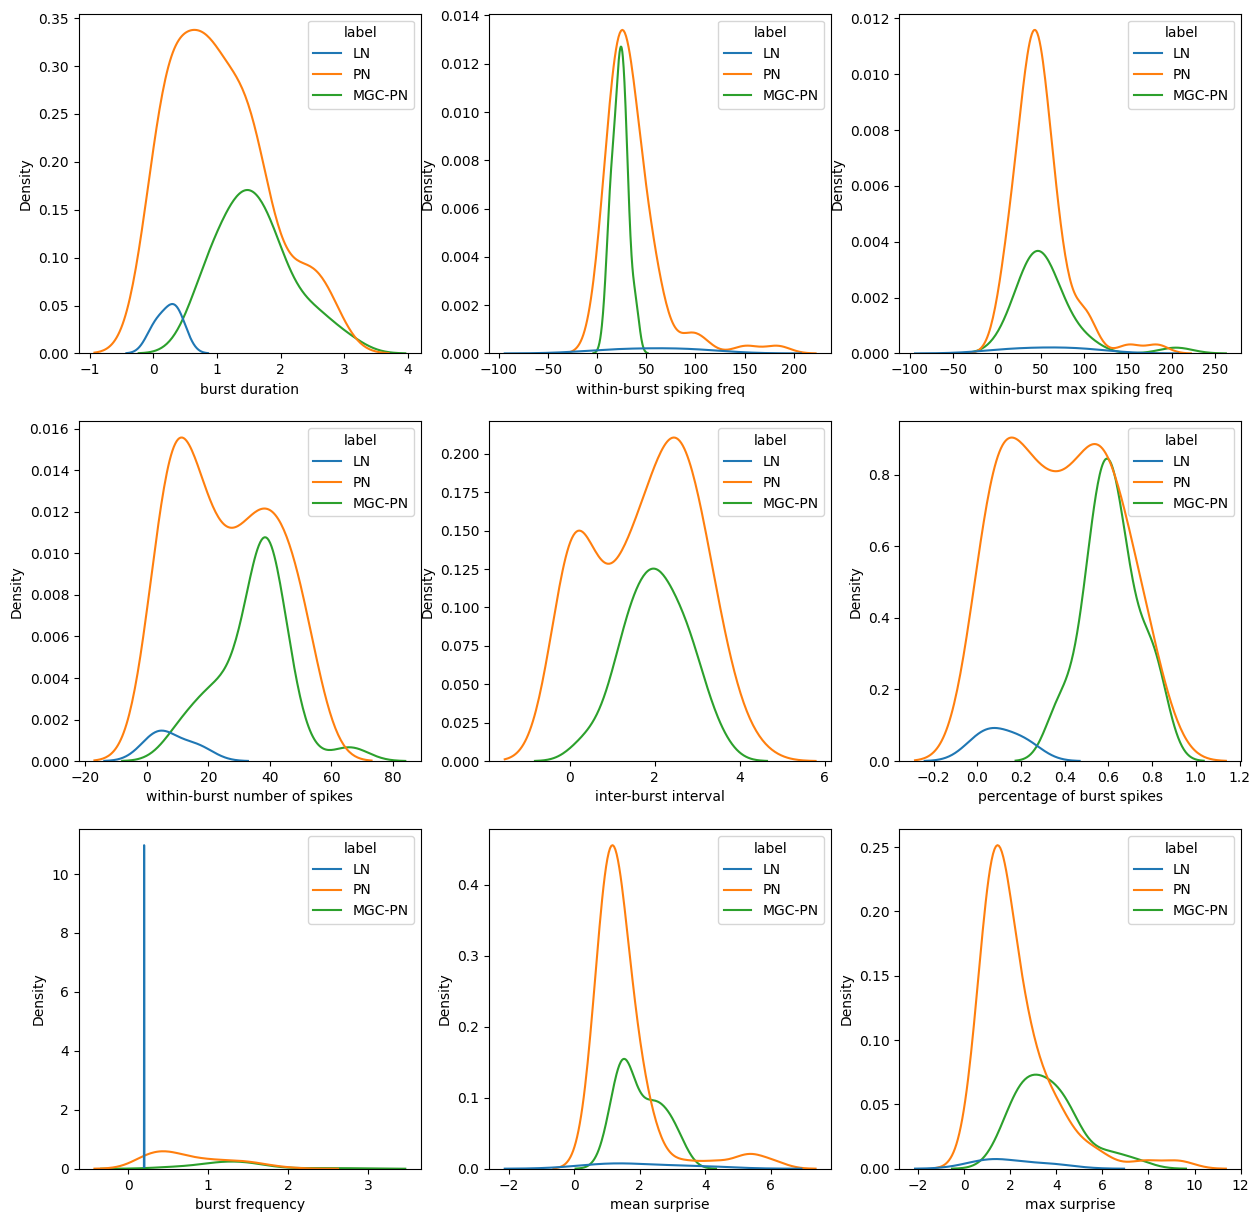

In [21]:
histoResults(df,lstColumnNames,sns.kdeplot,{'hue':'label'},'supervised_learning/real_label_kdeplot.jpg')

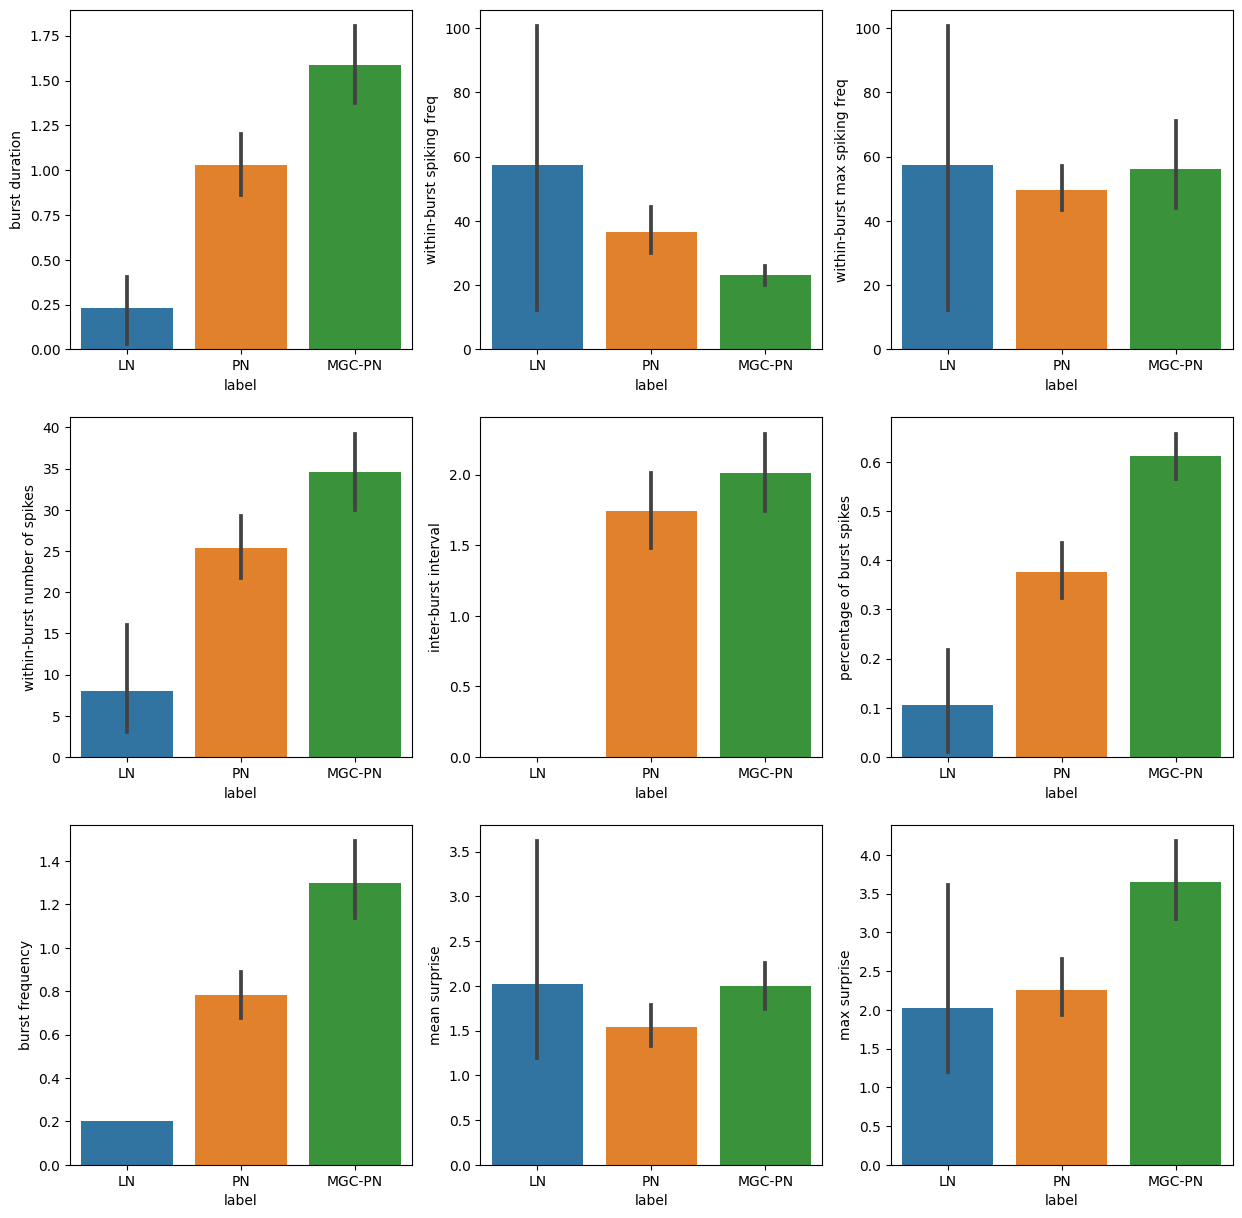

In [22]:
#barplot w.r.t. real label data
histoResults(df,lstColumnNames,
             sns.barplot,{'x':'label'},'supervised_learning/labeled_data_real_barplot.jpg',barplot=True)

LNandPN Data merged with verified labeled data, truncated version

In [11]:
#read from LNandPN.pkl file from labeled_data folder
spike_merged_truncated_df = pd.read_pickle('../labeled_data/spike_merged_truncated_df.pkl')

display(spike_merged_truncated_df)

,mothname,label,timestamps
0,060324124,0,"[0.10575, 0.45047000000000004, 0.5966, 0.9375,..."
1,071031003,0,"[0.00074, 0.019309999999999997, 0.04435, 0.069..."
2,071031001,0,"[0.013179999999999999, 0.02793, 0.05165, 0.076..."
3,071031005,0,"[0.00725, 0.02548, 0.053899999999999997, 0.069..."
4,071031006,0,"[0.005730000000000001, 0.02377, 0.03714, 0.050..."
...,...,...,...
477,ts_PN_CR050104B,1,"[10.221, 10.348, 10.52]"
478,ts_PN_CR050104B,1,[20.27]
479,ts_PN_CR050104B,1,"[30.306, 30.498, 30.612, 30.72]"
480,ts_PN_CR050104B,1,[40.329]


In [12]:
#conduct the same process on spike_merged_truncated_df
spike_merged_truncated_df_total_name = spike_merged_truncated_df['mothname']
spike_merged_truncated_df_total_label = spike_merged_truncated_df['label']
spike_merged_truncated_df_total_timestamps = spike_merged_truncated_df['timestamps']

#formulate dataset
spike_merged_truncated_df_sampleDataset,spike_merged_truncated_df_nameRes,spike_merged_truncated_df_labelRes,\
    spike_merged_truncated_df_no_burst_sampleDataset,\
        spike_merged_truncated_df_no_burst_nameRes,spike_merged_truncated_df_no_burst_labelRes\
          = formulateDataset(spike_merged_truncated_df_total_timestamps,\
                             spike_merged_truncated_df_total_name,spike_merged_truncated_df_total_label)


#pickle save sampleDataset
with open('supervised_spike_merged_truncated_df_sampleDataset.pkl','wb') as f:
    pickle.dump((spike_merged_truncated_df_sampleDataset,spike_merged_truncated_df_nameRes,spike_merged_truncated_df_labelRes,\
        spike_merged_truncated_df_no_burst_sampleDataset,\
            spike_merged_truncated_df_no_burst_nameRes,spike_merged_truncated_df_no_burst_labelRes),f)

In [13]:
display(len(spike_merged_truncated_df_no_burst_sampleDataset))

218

In [14]:
#supervised learning for spike_merged_truncated_df parameter data
spike_merged_truncated_df_sampleDataset,spike_merged_truncated_df_nameRes,spike_merged_truncated_df_labelRes,\
    spike_merged_truncated_df_no_burst_sampleDataset,\
        spike_merged_truncated_df_no_burst_nameRes,spike_merged_truncated_df_no_burst_labelRes\
            = pickle.load(open('supervised_spike_merged_truncated_df_sampleDataset.pkl','rb'))


spike_merged_truncated_df_nine_parameters_df = supervised_saveData(spike_merged_truncated_df_sampleDataset,spike_merged_truncated_df_nameRes,spike_merged_truncated_df_labelRes,\
    "~/Documents/GitHub/AL_generative/poissonSurprise/spike_merged_truncated_df_nine_burst_parameters.csv")

#save LNandPN_nine_parameters_df as pkl
spike_merged_truncated_df_nine_parameters_df.to_pickle("~/Documents/GitHub/AL_generative/poissonSurprise/LNandPN_nine_burst_parameters_df.pkl")

In [16]:
#shuffle spike_merged_truncated_df_nine_parameters_df by label
spike_merged_truncated_df_nine_parameters_df = shuffle(spike_merged_truncated_df_nine_parameters_df,random_state=42)
display(spike_merged_truncated_df_nine_parameters_df)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,label
68,0.003669,4088.307441,4088.307441,15,0.000000,1.000000,18.200018,12.161012,12.161012,ts_LN_CR020225B,0
194,0.003669,4088.307441,4088.307441,15,0.000000,1.000000,18.200018,12.161012,12.161012,ts_PN_CR021213A,1
82,0.000306,9803.921569,9803.921569,3,0.000000,1.000000,32.552083,4.971205,4.971205,ts_LN_CR020327A,0
247,0.000306,9803.921569,9803.921569,3,0.000000,1.000000,32.552083,4.971205,4.971205,ts_PN_CR040723A,1
109,0.000306,9803.921569,9803.921569,3,0.000000,1.000000,32.552083,4.971205,4.971205,ts_LN_CR031013A,0
...,...,...,...,...,...,...,...,...,...,...,...
20,0.002723,16892.884423,44563.279857,46,0.002118,0.807018,1614.478644,1.315502,2.504826,071016122,1
188,0.003669,4088.307441,4088.307441,15,0.000000,1.000000,18.200018,12.161012,12.161012,ts_PN_CR021105A,1
71,0.003669,4088.307441,4088.307441,15,0.000000,1.000000,18.200018,12.161012,12.161012,ts_LN_CR020311A,0
106,0.000306,9803.921569,9803.921569,3,0.000000,1.000000,32.552083,4.971205,4.971205,ts_LN_CR030710A,0


In [17]:
# #reduce dimensionality
# dim_reduction = KernelPCA(n_components=2,kernel='rbf',gamma=0.1)
# reduced_spike_merged_truncated_df_nine_parameters_df = dim_reduction.fit_transform(spike_merged_truncated_df_nine_parameters_df[lstColumnNames])

#load from pickle
# spike_merged_truncated_df_nine_parameters_df = pd.read_pickle("~/Documents/GitHub/AL_generative/poissonSurprise/LNandPN_nine_burst_parameters_df.pkl")

y = spike_merged_truncated_df_nine_parameters_df['label']
X = spike_merged_truncated_df_nine_parameters_df.iloc[:,:-2]




In [ ]:
# #optuna
# def xgb_objective(trial):
#     booster = trial.suggest_categorical('booster',['gbtree','dart'])
#     base_score = trial.suggest_float('base_score',0.1,0.9)
#     colsample_bylevel = trial.suggest_float('colsample_bylevel',0.1,0.9)
#     colsample_bytree = trial.suggest_float('colsample_bytree',0.1,0.9)
#     colsample_bynode = trial.suggest_float('colsample_bynode',0.1,0.9)
#     gamma = trial.suggest_float('gamma',0.1,2,log = True)
#     n_estimators = int(trial.suggest_float('n_estimators',100,10000,log = True))
#     learning_rate = trial.suggest_float('learning_rate',0.001,0.1,log=True)
#     max_delta_step = trial.suggest_float('max_delta_step',0,1.0)
#     max_depth = trial.suggest_int('max_depth',1,10)
#     min_child_weight = trial.suggest_int('min_child_weight',1,10)

#     objective = 'binary:logistic'

#     xgb = XGBClassifier(booster = booster,base_score = base_score,colsample_bylevel = colsample_bylevel,\
#                         colsample_bytree = colsample_bytree,colsample_bynode = colsample_bynode,\
#                             gamma = gamma,n_estimators = n_estimators,learning_rate = learning_rate,\
#                                 max_delta_step = max_delta_step,max_depth = max_depth,\
#                                     min_child_weight = min_child_weight,objective = objective)
    
#     #cross validation predict
#     y_predict_proba = cross_val_predict(xgb,X,y,cv=5,method='predict_proba')

#     # #f1 score
#     # f1 = f1_score(y,y_predict_proba[:,1]>0.5)

#     #roc_auc_score
#     auc = roc_auc_score(y,y_predict_proba[:,1],average='weighted',multi_class='ovr')

#     return auc

# study = optuna.create_study(direction='maximize')
# study.optimize(xgb_objective, n_trials=100)

In [19]:
#train an xgboolst classifier with the optimal parameters and save the model
optuna_params = {'booster': 'gbtree', 'base_score': 0.8065337488552505, \
                 'colsample_bylevel': 0.7432234751522759, 'colsample_bytree': 0.13804248742741376, \
                    'colsample_bynode': 0.48830341438641134, 'gamma': 0.12174816724286465, \
                        'n_estimators': int(908.3652551410993), 'learning_rate': 0.08413983051565382, \
                            'max_delta_step': 0.14983287164037207, 'max_depth': 2, 'min_child_weight': 5}

opt_xgb = XGBClassifier(**optuna_params)

#save_model
opt_xgb.fit(X,y)

XGBClassifier(base_score=0.8065337488552505, booster='gbtree', callbacks=None,
              colsample_bylevel=0.7432234751522759,
              colsample_bynode=0.48830341438641134,
              colsample_bytree=0.13804248742741376, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.12174816724286465,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08413983051565382,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0.14983287164037207, max_depth=2, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=908, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
#display balanced accuracy score on training set
y_pred = opt_xgb.predict(X)
print('Balanced accuracy score on training set: ',\
      balanced_accuracy_score(y_pred,y))

Balanced accuracy score on training set:  0.7765151515151515


In [14]:
#earliest data


with open('unsupervised_learning/spontaneous_sampleDataset.pkl', 'rb') as f:
    sampleDataset,nameRes, neuronRes, stimuliRes,\
    no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes = pickle.load(f)

def saveData(Dataset,nameRes,neuronRes,stimuliRes):
    #load data from csv file
    savePath =  'unsupervised_learning/spontaneous_nine_parameters.csv'

    df = pd.DataFrame(Dataset,columns=\
                      ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
                       'within-burst number of spikes',\
                       'inter-burst interval','percentage of burst spikes','burst frequency',\
                        'mean surprise','max surprise'])
    
    #also include subject and stimuli name
    df['Subject'] = nameRes
    df['Neuron'] = neuronRes
    df['Stimuli'] = stimuliRes
    
    df.to_csv(savePath, index=False)
    return df


df = saveData(sampleDataset,nameRes,neuronRes,stimuliRes)
    
df_X = df.drop(['Subject','Neuron','Stimuli'],axis=1)



In [16]:
y_pred = opt_xgb.predict(df_X)
df_X['pred_label'] = y_pred
display(y_pred)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
y_pred_proba = cross_val_predict(opt_xgb,X,y,cv=5,method='predict_proba')
y_pred = y_pred_proba[:,1]>0.5

#f1 score
f1 = f1_score(y,y_pred)
#accuracy
accu = accuracy_score(y,y_pred)
#AUC
auc = roc_auc_score(y,y_pred_proba[:,1])

print('F1 score: ',f1)
print('Accuracy: ',accu)
print('AUC: ',auc)


# in 'label' and 'pred_label' change 1 back to 'PN' and 0 back to 'LN'
spike_merged_truncated_df_nine_parameters_df['pred_label'] = y_pred

F1 score:  0.8742004264392325
Accuracy:  0.7765151515151515
AUC:  0.5352211657709797


In [ ]:
# #in 'label' and 'pred_label' change 1 back to 'PN' and 0 back to 'LN'
# DT_LNandPN_DF['label'] = DT_LNandPN_DF['label'].replace([1,0],['PN','LN'])
# DT_LNandPN_DF['pred_label'] = DT_LNandPN_DF['pred_label'].replace([1,0],['PN','LN'])

# DT_LNandPN_reducedSampleDF['label'] = DT_LNandPN_reducedSampleDF['label'].replace([1,0],['PN','LN'])
# DT_LNandPN_reducedSampleDF['pred_label'] = DT_LNandPN_reducedSampleDF['pred_label'].replace([1,0],['PN','LN'])

# in 'label' and 'pred_label' change 1 back to 'PN' and 0 back to 'LN'
XGB_spike_merged_DF['label'] = XGB_spike_merged_DF['label'].replace([1,0],['PN','LN'])
XGB_spike_merged_DF['pred_label'] = XGB_spike_merged_DF['pred_label'].replace([1,0],['PN','LN'])

XGB_spike_merged_reducedSampleDF['label'] = XGB_spike_merged_reducedSampleDF['label'].replace([1,0],['PN','LN'])
XGB_spike_merged_reducedSampleDF['pred_label'] = XGB_spike_merged_reducedSampleDF['pred_label'].replace([1,0],['PN','LN'])

LNandPN Data merged with verified labeled data

In [40]:
#read from LNandPN.pkl file from labeled_data folder
spike_merged_df = pd.read_pickle('../labeled_data/spike_merged_df.pkl')

display(spike_merged_df)

,mothname,label,timestamps
0,060324124,0,"[0.10575, 0.45047000000000004, 0.5966, 0.9375,..."
1,071031003,0,"[0.00074, 0.019309999999999997, 0.04435, 0.069..."
2,071031001,0,"[0.013179999999999999, 0.02793, 0.05165, 0.076..."
3,071031005,0,"[0.00725, 0.02548, 0.053899999999999997, 0.069..."
4,071031006,0,"[0.005730000000000001, 0.02377, 0.03714, 0.050..."
...,...,...,...
127,ts_PN_CR040914A,1,"[0.02805, 0.0454, 0.06255, 0.0809, 0.11385, 0...."
128,ts_PN_CR040916A,1,"[0.527, 0.58105, 0.77755, 0.86615, 0.8882, 10...."
129,ts_PN_CR040920A,1,"[2.9203, 2.9982, 3.0742, 3.1502, 3.2127, 3.271..."
130,ts_PN_CR050104A,1,"[0.0685, 0.12855, 0.16985, 0.22035, 0.2668, 0...."


In [14]:
spike_merged_df_total_name = spike_merged_df['mothname']
spike_merged_df_total_label = spike_merged_df['label']
spike_merged_df_total_timestamps = spike_merged_df['timestamps']

#formulate dataset
spike_merged_df_sampleDataset,spike_merged_df_nameRes,spike_merged_df_labelRes,\
    spike_merged_df_no_burst_sampleDataset,\
        spike_merged_df_no_burst_nameRes,spike_merged_df_no_burst_labelRes\
          = formulateDataset(spike_merged_df_total_timestamps,\
                             spike_merged_df_total_name,spike_merged_df_total_label)

#pickle save sampleDataset
try:
    with open('supervised_spike_merged_df_sampleDataset.pkl','wb') as f:
        pickle.dump((spike_merged_df_sampleDataset,spike_merged_df_nameRes,spike_merged_df_labelRes,\
            spike_merged_df_no_burst_sampleDataset,\
                spike_merged_df_no_burst_nameRes,spike_merged_df_no_burst_labelRes),f)

except:
    pass
    
#supervised learning for spike_merged_df parameter data
spike_merged_df_sampleDataset,spike_merged_df_nameRes,spike_merged_df_labelRes,\
    spike_merged_df_no_burst_sampleDataset,\
        spike_merged_df_no_burst_nameRes,spike_merged_df_no_burst_labelRes\
            = pickle.load(open('supervised_spike_merged_df_sampleDataset.pkl','rb'))

spike_merged_df_nine_parameters_df = supervised_saveData(spike_merged_df_sampleDataset,spike_merged_df_nameRes,spike_merged_df_labelRes,\
    "~/Documents/GitHub/AL_generative/poissonSurprise/spike_merged_df_nine_burst_parameters.csv")

#save LNandPN_nine_parameters_df as pkl
spike_merged_df_nine_parameters_df.to_pickle("~/Documents/GitHub/AL_generative/poissonSurprise/LNandPN_nine_burst_parameters_df.pkl")

display(spike_merged_df_nine_parameters_df)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,label
0,0.000403,12418.966245,12418.966245,5,0.000000,0.217391,201.957371,1.192730,1.192730,060324124,0
1,0.000030,100704.934542,100704.934542,3,0.000000,0.010563,200.198196,3.615758,3.615758,071031005,0
2,0.002299,23057.412958,81081.081081,53,0.001794,0.768116,1722.686271,1.314830,1.999648,070928020,1
3,0.001485,17510.657929,31776.294884,26,0.001732,0.530612,800.345749,2.094349,2.472035,070928013,1
4,0.002747,16016.482416,37309.952430,44,0.001188,0.721311,1603.630620,1.324212,2.335223,070928016,1
...,...,...,...,...,...,...,...,...,...,...,...
114,0.029698,3131.471286,20833.333333,93,0.010481,0.930000,171.144960,8.138343,24.376297,ts_PN_CR040723A,1
115,0.014148,15478.946159,75685.903500,219,0.000777,0.943966,601.202405,5.027307,8.595686,ts_PN_CR040914A,1
116,0.030141,5076.125291,10522.623641,153,0.010289,0.987097,121.820485,11.618986,24.205032,ts_PN_CR040916A,1
117,0.011717,8961.185266,15118.427684,105,0.000078,0.981308,134.039274,6.169706,9.239340,ts_PN_CR040920A,1


In [19]:
display(countSamples(spike_merged_df_nine_parameters_df))

defaultdict(int, {0: 19, 1: 100})

In [34]:
display(lstColumnNames := list(spike_merged_df_nine_parameters_df.columns[:-2]))

NameError: name 'spike_merged_df_nine_parameters_df' is not defined

In [21]:
#supervised

#TSNE
TSNEparams = {'n_components':2,'random_state':42}

#KPCA
KPCAparams = {'n_components':2,'kernel':'linear'}

#Logistic Regression Classifier
LRparams = {'penalty':['l2','elasticnet',None],\
            'solver':['lbfgs','liblinear',\
                'newton-cg','newton-cholesky',\
                    'sag','saga'],\
                        'max_iter':[1000],'random_state':[42],\
                            'class_weight':[{0:1,1:3},\
                                            {0:1,1:5},\
                                                {0:1,1:7},\
                                                    {0:1,1:9}]}



#Decision Tree Classifier
DTparams = {'criterion':['gini','entropy'],\
            'splitter':['best','random'],\
                'max_depth':[None,1,2,3,4,5,6,7,8,9,10],\
                    'min_samples_split':[2,3,4,5,6,7,8,9,10],\
                        'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],\
                            'max_features':[None,'auto','sqrt','log2'],\
                                'random_state':[42],\
                                    'class_weight':[{0:1,1:3}]}

#XGBoost Classifier with tree as base_estimator
XGBparams = {'learning_rate':[0.01,0.05],\
            'max_depth':[3,4,5,6,7],\
                'min_child_weight':[1,2,3,4,5,6],\
                    'gamma':[0.0,0.1,0.2],\
                        'colsample_bytree':[0.3,0.4,0.5],\
                            'n_estimators':[100,200,300],\
                                'objective':['binary:logistic'],\
                                    'random_state':[42],'weights':['balanced']}

#XGBoost Classifier with logistic regression as base_estimator
XGBparams_gblinear = {'lambda':[0.01,0.05,0.1,0.5,1,5,10],\
                      'alpha':[0.01,0.05,0.1,0.5,1,5,10],\
                'lambda_bias':[0.01,0.05,0.1,0.5,1,5,10],\
                    'n_estimators':[100,200,300],\
                        'objective':['binary:logistic'],\
                            'random_state':[42],'weights':['balanced']}





In [19]:
display(spike_merged_df_nine_parameters_df)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,label
0,0.000403,12418.966245,12418.966245,5,0.000000,0.217391,201.957371,1.192730,1.192730,060324124,0
1,0.000030,100704.934542,100704.934542,3,0.000000,0.010563,200.198196,3.615758,3.615758,071031005,0
2,0.002299,23057.412958,81081.081081,53,0.001794,0.768116,1722.686271,1.314830,1.999648,070928020,1
3,0.001485,17510.657929,31776.294884,26,0.001732,0.530612,800.345749,2.094349,2.472035,070928013,1
4,0.002747,16016.482416,37309.952430,44,0.001188,0.721311,1603.630620,1.324212,2.335223,070928016,1
...,...,...,...,...,...,...,...,...,...,...,...
114,0.029698,3131.471286,20833.333333,93,0.010481,0.930000,171.144960,8.138343,24.376297,ts_PN_CR040723A,1
115,0.014148,15478.946159,75685.903500,219,0.000777,0.943966,601.202405,5.027307,8.595686,ts_PN_CR040914A,1
116,0.030141,5076.125291,10522.623641,153,0.010289,0.987097,121.820485,11.618986,24.205032,ts_PN_CR040916A,1
117,0.011717,8961.185266,15118.427684,105,0.000078,0.981308,134.039274,6.169706,9.239340,ts_PN_CR040920A,1


In [22]:

lstColumnNames = list(spike_merged_df_nine_parameters_df.columns[:-2])
#train with xgb and reduce dimension for visualization for spike_merged_df
XGB_spike_merged_DF,XGB_spike_merged_reducedSampleDF,XGB_spike_merged_dclf = reductionClassification(spike_merged_df_nine_parameters_df,lstColumnNames,\
                                                            KernelPCA,KPCAparams,\
                                                            XGBClassifier(),XGBparams,\
                                                            shuffleRandomState = 42,isShuffle = True)


#print dclf parameters
print(XGB_spike_merged_dclf)

#get accuracy on all data by comparing label to pred_label
print('Accuracy on all data: ',accuracy_score(XGB_spike_merged_DF['label'],XGB_spike_merged_DF['pred_label']))

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, random_state=42, weights=balanced; F1: (test=0.909) accu: (test=0.833) auc: (test=0.925) total time=   0.2s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, random_state=42, weights=balanced; F1: (test=0.909) accu: (test=0.833) auc: (test=0.738) total time=   0.2s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, random_state=42, weights=balanced; F1: (test=0.909) accu: (test=0.833) auc: (test=0.912) total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, objective=binary:logistic, random_state=42, weights=balanced; 

In [23]:
#save the dclf model
pickle.dump(XGB_spike_merged_dclf,open('supervised_learning/XGB_spike_merged_dclf.pkl','wb'))

In [24]:
#F1 Score
print('F1 Score on all data: ',f1_score(XGB_spike_merged_DF['label'],XGB_spike_merged_DF['pred_label']))

#AUC
print('AUC on all data: ',roc_auc_score(XGB_spike_merged_DF['label'],XGB_spike_merged_DF['pred_label']))

#accuracy
print('Accuracy on all data: ',accuracy_score(XGB_spike_merged_DF['label'],XGB_spike_merged_DF['pred_label']))

F1 Score on all data:  0.9282296650717704
AUC on all data:  0.6692105263157895
Accuracy on all data:  0.8739495798319328


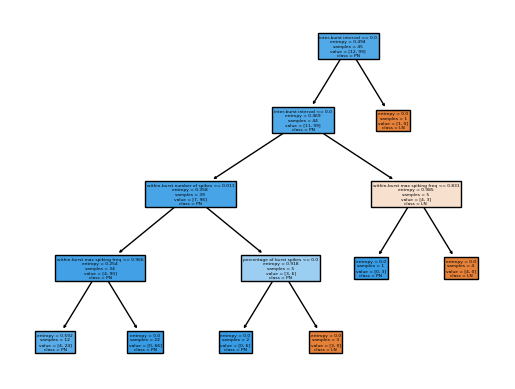

<Figure size 3000x3000 with 0 Axes>

In [21]:
# #plot best tree estimator
# tree.plot_tree(DT_dclf,\
#                feature_names = lstColumnNames,\
#                 class_names = ['LN','PN'],filled = True)

# fig = plt.figure(figsize=(30,30))

# #save tree plot on fig
# fig.savefig('LNandPN_DT_best_estimator.jpg')

In [1]:
# #in 'label' and 'pred_label' change 1 back to 'PN' and 0 back to 'LN'
# DT_LNandPN_DF['label'] = DT_LNandPN_DF['label'].replace([1,0],['PN','LN'])
# DT_LNandPN_DF['pred_label'] = DT_LNandPN_DF['pred_label'].replace([1,0],['PN','LN'])

# DT_LNandPN_reducedSampleDF['label'] = DT_LNandPN_reducedSampleDF['label'].replace([1,0],['PN','LN'])
# DT_LNandPN_reducedSampleDF['pred_label'] = DT_LNandPN_reducedSampleDF['pred_label'].replace([1,0],['PN','LN'])

# in 'label' and 'pred_label' change 1 back to 'PN' and 0 back to 'LN'
XGB_spike_merged_DF['label'] = XGB_spike_merged_DF['label'].replace([1,0],['PN','LN'])
XGB_spike_merged_DF['pred_label'] = XGB_spike_merged_DF['pred_label'].replace([1,0],['PN','LN'])

XGB_spike_merged_reducedSampleDF['label'] = XGB_spike_merged_reducedSampleDF['label'].replace([1,0],['PN','LN'])
XGB_spike_merged_reducedSampleDF['pred_label'] = XGB_spike_merged_reducedSampleDF['pred_label'].replace([1,0],['PN','LN'])

NameError: name 'XGB_spike_merged_DF' is not defined

In [29]:
display(XGB_spike_merged_reducedSampleDF)

,PC1,PC2,Subject,label,pred_label
0,0.118798,-0.023892,060324124,LN,LN
1,0.352521,0.033970,071031005,LN,PN
2,0.022616,-0.032135,070928020,PN,PN
3,-0.217708,-0.002777,070928013,PN,PN
4,-0.287774,0.017061,070928016,PN,PN
...,...,...,...,...,...
114,-0.335177,0.035989,ts_PN_CR040723A,PN,PN
115,-0.322940,0.025250,ts_PN_CR040914A,PN,PN
116,0.313949,0.020643,ts_PN_CR040916A,PN,PN
117,-0.029030,-0.023604,ts_PN_CR040920A,PN,PN


<Axes: xlabel='PC1', ylabel='PC2'>

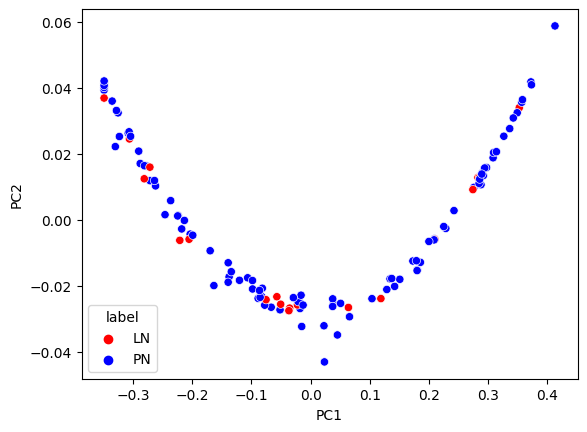

In [26]:
#PN must be red, LN must be blue
cols = ['blue' if x == 'PN' else 'red' for x in ['PN','LN']]

sns.scatterplot(data = XGB_spike_merged_reducedSampleDF, x ='PC1', y = 'PC2',\
                hue = 'label', palette = ['red','blue'])



<Axes: xlabel='PC1', ylabel='PC2'>

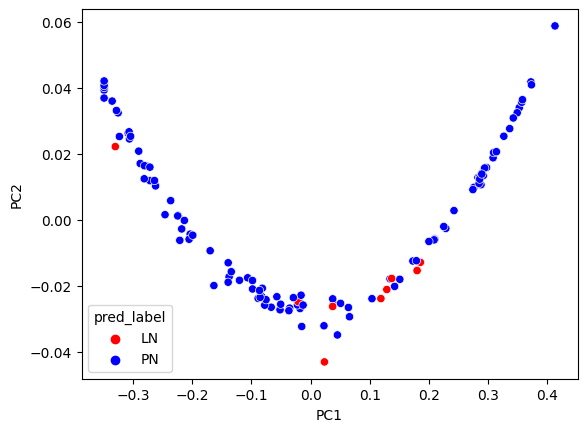

In [28]:
sns.scatterplot(data =  XGB_spike_merged_reducedSampleDF, x ='PC1', y = 'PC2',\
                hue = 'pred_label', palette = ['red','blue'])

In [ ]:
#classificationResultPlot(DT_LNandPN_reducedSampleDF,'LNandPN_DT.jpg',cols)

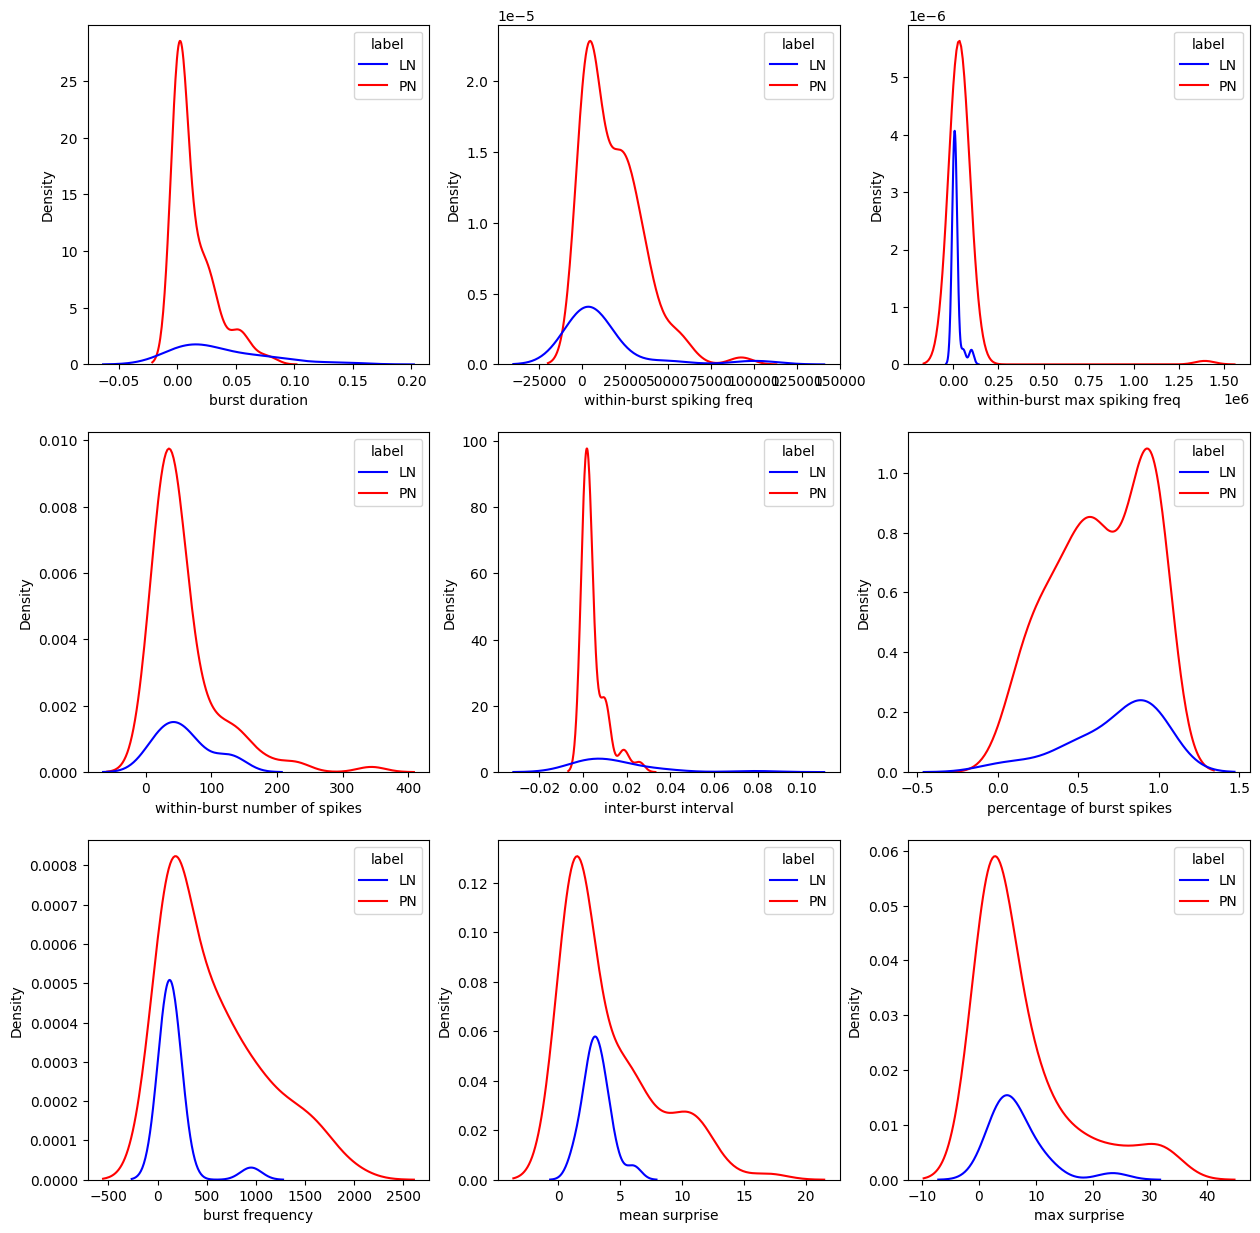

In [59]:
#kdeplot
histoResults(XGB_spike_merged_DF,lstColumnNames,sns.kdeplot,\
             {'hue':'label','palette':cols},'MergedDF_XGBoost_kdeplot.jpg')

In [21]:
lstColumnNames = list(spike_merged_truncated_df_nine_parameters_df.columns[:-2])
display(lstColumnNames)

['burst duration',
 'within-burst spiking freq',
 'within-burst max spiking freq',
 'within-burst number of spikes',
 'inter-burst interval',
 'percentage of burst spikes',
 'burst frequency',
 'mean surprise',
 'max surprise']

In [26]:
#replace label 0 with 'LN' and label 1 with 'PN'
spike_merged_truncated_df_nine_parameters_df['label'] = spike_merged_truncated_df_nine_parameters_df['label'].replace([1,0],['PN','LN'])

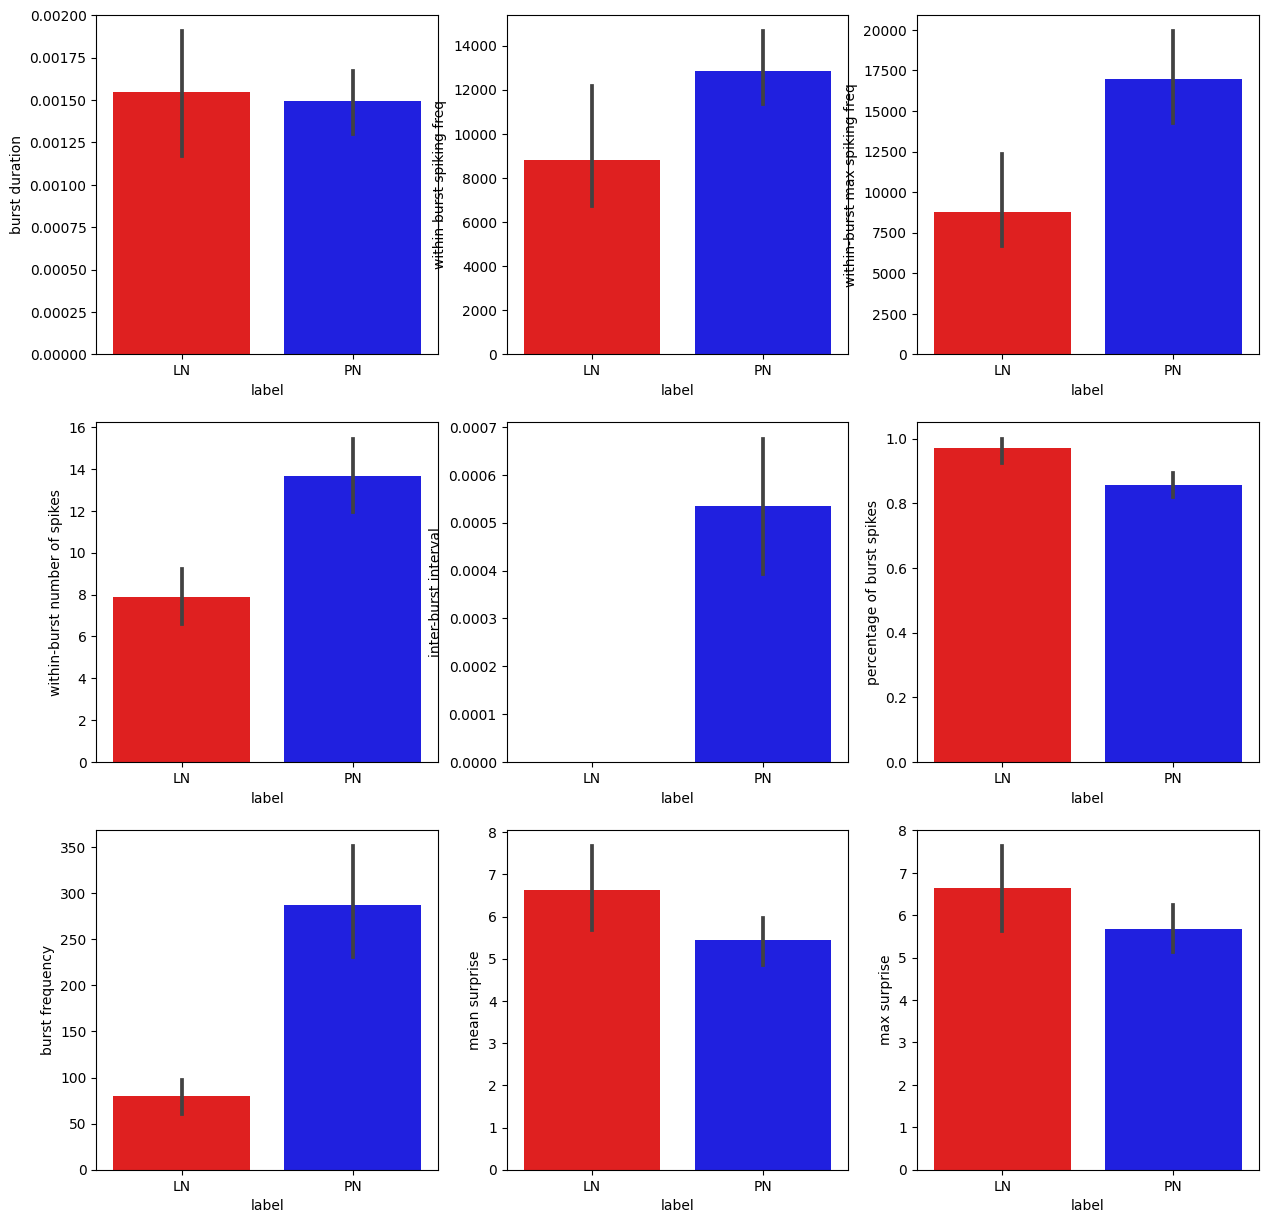

In [27]:
histoResults(spike_merged_truncated_df_nine_parameters_df,lstColumnNames,sns.barplot,\
             {'x':'label','palette':['red','blue']},'Merged_Labeled_Data_barplot.jpg',barplot=True)

Labeled Data

In [5]:
for index,row in spike_df.iterrows():
    print(index,list(spike_df['timestamps'][index]))

print(np.argmax(np.array(list(spike_df['timestamps'][i][-1]-spike_df['timestamps'][i][0]\
                               for i in range(len(spike_df))))))
print(np.max(np.array(list(spike_df['timestamps'][i][-1]-spike_df['timestamps'][i][0]\
                               for i in range(len(spike_df))))))


0 [0.10575, 0.45047000000000004, 0.5966, 0.9375, 1.17306, 1.379, 1.7181199999999999, 1.94152, 2.03174, 2.17787, 2.3428400000000003, 2.49844, 2.59511, 2.5952100000000002, 2.74545, 2.81881, 3.0254000000000003, 3.3226, 3.5728899999999997, 3.68236, 4.0863499999999995, 4.428850000000001, 4.86191, 4.95154]
1 [0.00074, 0.019309999999999997, 0.04435, 0.06973, 0.08614, 0.11314, 0.12946000000000002, 0.14607, 0.17091, 0.19262, 0.21462, 0.24337999999999999, 0.25936000000000003, 0.27886, 0.30228, 0.33232, 0.34996, 0.36138, 0.37989999999999996, 0.39994, 0.42410000000000003, 0.44183999999999996, 0.46722, 0.49069, 0.51083, 0.5258200000000001, 0.54915, 0.57174, 0.58266, 0.6156900000000001, 0.63113, 0.64097, 0.66224, 0.67861, 0.7009, 0.72129, 0.7376, 0.75725, 0.77352, 0.78704, 0.80522, 0.82311, 0.8435900000000001, 0.86598, 0.89739, 0.9240499999999999, 0.9532, 0.9750599999999999, 1.00338, 1.01548, 1.0155800000000001, 1.03518, 1.04876, 1.06664, 1.0835899999999998, 1.10898, 1.13127, 1.1611099999999999, 1.1

TS Files

In [6]:
#read LNandPN
LNandPN = pd.read_pickle("LNandPN.pkl")

for index,row in LNandPN.iterrows():
    print(index,list(LNandPN['timestamps'][index]))

print(np.argmax(np.array(list(LNandPN['timestamps'][i][-1]-LNandPN['timestamps'][i][0] for i in range(len(LNandPN))))))

0 [4.726, 4.8962, 5.0404, 5.2076, 5.3746, 5.5308, 5.6765, 10.105, 10.221, 10.348, 10.52, 20.092, 20.27, 30.125, 30.306, 30.498, 30.612, 30.72, 40.188, 40.329, 50.087, 51.058, 51.264, 51.473, 51.796, 52.238, 52.583, 52.818, 53.0, 53.235, 53.531, 53.793, 54.036, 54.204, 54.515, 54.727, 54.945, 60.533, 61.539, 62.074, 62.454, 62.712, 63.021, 63.301, 63.569, 64.238, 64.619]
1 [0.16865, 0.37665, 0.58105, 0.70655, 0.7886, 0.94095, 1.1698, 1.2839, 1.4269, 1.6007, 1.7456, 1.7457, 1.8351, 1.9566, 1.9567, 2.0517, 2.1789, 2.3043, 2.4242, 2.5351, 2.6197, 2.6984, 2.8319, 2.954, 3.0434, 3.1792, 3.2664, 3.4183, 3.5176, 3.6093, 3.7028, 3.7029, 3.807, 3.8989, 3.9589, 4.0656, 4.1619, 4.2655, 4.3255, 4.495, 4.5726, 4.6593, 4.7474, 4.8252, 4.9097, 4.9923, 5.0691, 5.1746, 5.2691, 5.3552, 5.4963, 5.6027, 5.6978, 5.7964, 5.8586, 5.9505, 10.169, 10.325, 10.485, 10.728, 10.845, 10.987, 11.19, 11.333, 11.415, 11.613, 11.733, 11.935, 11.993, 12.282, 12.44, 12.674, 12.856, 13.148, 13.254, 13.438, 13.735, 13.894, 

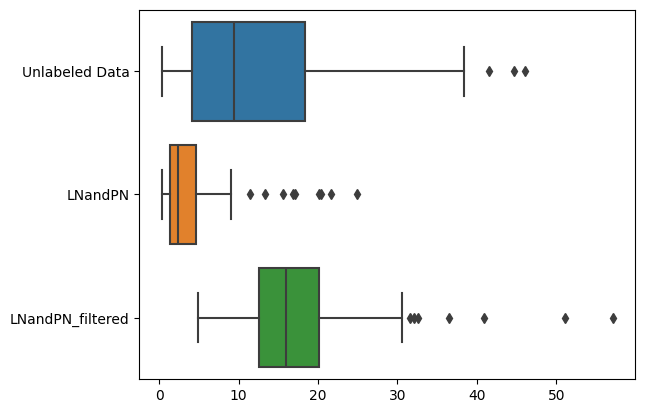

In [16]:
# for index in range(len(totalDf)):
#     print(index)
#     print(countSpikingFreq([totalDf[index]]))

#Unlabeled Data
#plot index,spiking frequency
spikingFreq_unlabeled = []
for index in range(len(totalDf)):
    spikingFreq_unlabeled.append(countSpikingFreq([totalDf[index]]))


# plt.plot(spikingFreq,color='blue')




#LNandPN
# for index,row in LNandPN.iterrows():
#     print(index)
#     print(countSpikingFreq([LNandPN['timestamps'][index]]))

#plot index,spiking frequency
spikingFreq_lnandpn = []
for index,row in LNandPN.iterrows():
    spikingFreq_lnandpn.append(countSpikingFreq([LNandPN['timestamps'][index]]))


#second labeled data
spikingFreq_lnpnfiltered = []
for index,row in spike_df.iterrows():
    spikingFreq_lnpnfiltered.append(countSpikingFreq([spike_df['timestamps'][index]]))

spiking_freq = spikingFreq_unlabeled + spikingFreq_lnandpn + spikingFreq_lnpnfiltered
spiking_freq_labels = ['Unlabeled Data']*len(spikingFreq_unlabeled) + \
    ['LNandPN']*len(spikingFreq_lnandpn) +\
        ['LNandPN_filtered']*len(spikingFreq_lnpnfiltered)

sns.boxplot(x = spiking_freq,y=spiking_freq_labels)
# plt.plot(spikingFreq,color='red')
# plt.legend(['Unlabeled Data','LNandPN'])
# plt.xlabel('index')
# plt.ylabel('spiking frequency')
# plt.title('spiking frequency for each sample')

#save figure with size 15,15
plt.savefig('spiking_freq.jpg',bbox_inches='tight',dpi=300)


plt.show()

In [4]:
#supervised learning for spike_merged_df parameter data
LNandPN_df_sampleDataset,LNandPN_df_nameRes,LNandPN_df_labelRes,\
    LNandPN_df_no_burst_sampleDataset,\
        LNandPN_df_no_burst_nameRes,LNandPN_df_no_burst_labelRes\
            = formulateDataset(LNandPN['timestamps'],LNandPN['mothname'],LNandPN['label'])

LNandPN_df_nine_parameters_df = supervised_saveData(LNandPN_df_sampleDataset,LNandPN_df_nameRes,LNandPN_df_labelRes,\
    "~/Documents/GitHub/AL_generative/poissonSurprise/LNandPN_df_nine_burst_parameters.csv")


In [5]:
#save LNandPN_nine_parameters_df as pkl
LNandPN_df_nine_parameters_df.to_pickle("~/Documents/GitHub/AL_generative/poissonSurprise/LNandPN_nine_burst_parameters_df.pkl")

display(LNandPN_df_nine_parameters_df)

#count number of samples for each class in df
count = countSamples(LNandPN_df_nine_parameters_df)
display(count)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,label
0,0.024163,1655.403029,7455.268390,40,0.035349,0.869565,77.376623,3.785197,6.606620,ts_LN_CR020108A,0
1,0.006714,9532.391513,12096.774194,64,0.023597,0.477612,113.147771,3.330612,8.910360,ts_LN_CR020115A,0
2,0.063776,752.628319,2355.157796,48,0.078496,0.727273,62.486982,2.000355,4.948261,ts_LN_CR020208A,0
3,0.088818,720.574658,15406.162465,64,0.011019,0.941176,109.235353,4.558693,12.350901,ts_LN_CR020221A,0
4,0.066259,1131.921701,4479.840717,75,0.001570,1.000000,113.104579,3.160761,7.586543,ts_LN_CR020225B,0
...,...,...,...,...,...,...,...,...,...,...,...
60,0.029698,3131.471286,20833.333333,93,0.010481,0.930000,171.144960,8.138343,24.376297,ts_PN_CR040723A,1
61,0.014148,15478.946159,75685.903500,219,0.000777,0.943966,601.202405,5.027307,8.595686,ts_PN_CR040914A,1
62,0.030141,5076.125291,10522.623641,153,0.010289,0.987097,121.820485,11.618986,24.205032,ts_PN_CR040916A,1
63,0.011717,8961.185266,15118.427684,105,0.000078,0.981308,134.039274,6.169706,9.239340,ts_PN_CR040920A,1


defaultdict(int, {0: 17, 1: 48})

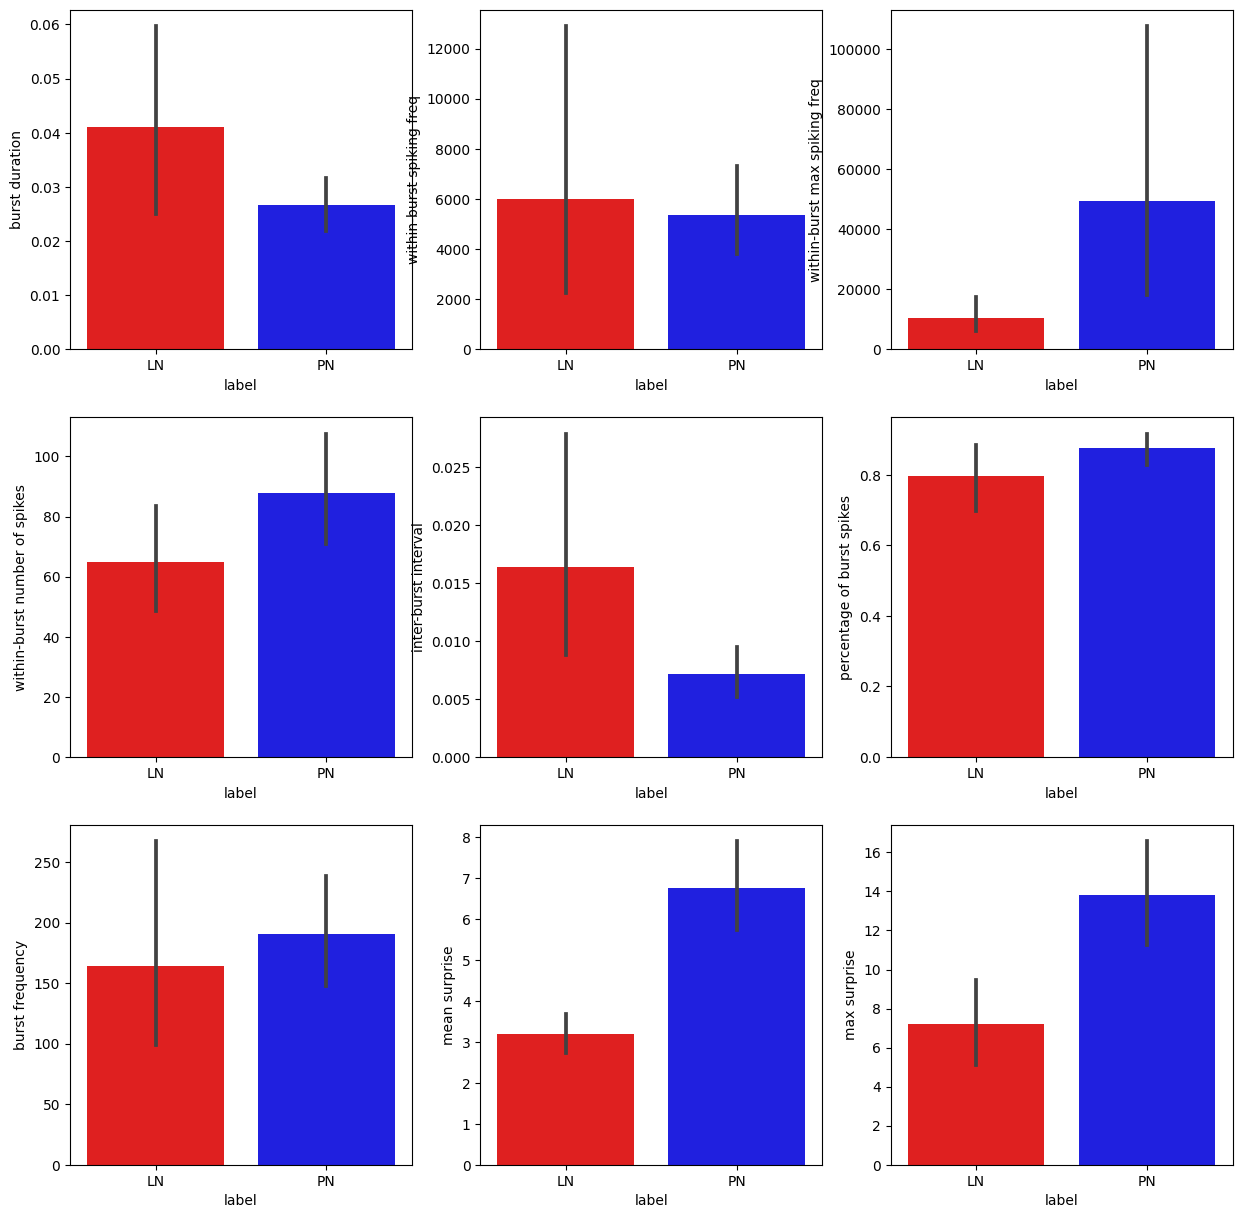

In [34]:
lstColumnNames = list(LNandPN_df_nine_parameters_df.columns[:-2])
#replace label 0 with 'LN' and label 1 with 'PN'
LNandPN_df_nine_parameters_df['label'] = LNandPN_df_nine_parameters_df['label'].replace([1,0],['PN','LN'])
#histogram
histoResults(LNandPN_df_nine_parameters_df,lstColumnNames,sns.barplot,\
             {'x':'label','palette':['red','blue']},'LNandPN_barplot.jpg',barplot=True)

In [43]:
# #SGD Classifier
# SGDparams = {'alpha':[0.0001,0.001,0.01,0.1,1],\
#              'loss':['log','modified_huber','squared_hinge',\
#                      'perceptron','squared_loss','huber','epsilon_insensitive',\
#                          'squared_epsilon_insensitive'],\
#                              'penalty':['l1','l2','elasticnet'],\
#                                          'random_state':[42],\
#                                              'class_weight':[{0:1,1:3},\
#                                                              {0:1,1:5},\
#                                                                  {0:1,1:7},\
#                                                                      {0:1,1:9}]}

# SGD_LNandPN_DF,SGD_LNandPN_reducedSampleDF = reductionClassification(LNandPN_nine_parameters_df,lstColumnNames,\
#                                                              KernelPCA,KPCAparams,\
#                                                              SGDClassifier(),SGDparams,\
#                                                              shuffleRandomState = 42,isShuffle = True)

# classificationResultPlot(SGD_LNandPN_reducedSampleDF,'LNandPN_SGD.jpg')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV 1/5] END alpha=0.0001, class_weight={0: 1, 1: 3}, loss=log, penalty=l1, random_state=42; F1: (test=0.800) accu: (test=0.667) auc: (test=0.667) total time=   0.0s
[CV 2/5] END alpha=0.0001, class_weight={0: 1, 1: 3}, loss=log, penalty=l1, random_state=42; F1: (test=0.800) accu: (test=0.667) auc: (test=0.611) total time=   0.0s
[CV 3/5] END alpha=0.0001, class_weight={0: 1, 1: 3}, loss=log, penalty=l1, random_state=42; F1: (test=0.875) accu: (test=0.778) auc: (test=0.857) total time=   0.0s
[CV 4/5] END alpha=0.0001, class_weight={0: 1, 1: 3}, loss=log, penalty=l1, random_state=42; F1: (test=0.000) accu: (test=0.222) auc: (test=1.000) total time=   0.0s
[CV 5/5] END alpha=0.0001, class_weight={0: 1, 1: 3}, loss=log, penalty=l1, random_state=42; F1: (test=0.875) accu: (test=0.778) auc: (test=0.286) total time=   0.0s
[CV 1/5] END alpha=0.0001, class_weight={0: 1, 1: 3}, loss=log, penalty=l2, random_state=42; F1: (test=0.8

TypeError: 'float' object is not subscriptable

In [22]:
#keras neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing
#normalize data

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import SGD



In [23]:
#build model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=9))
#add dropout layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='tanh'))

#compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#extract X and y from spike_merged_df_nine_parameters_df with cross validation
X = spike_merged_df_nine_parameters_df[lstColumnNames]
y = spike_merged_df_nine_parameters_df['label']

#split into training and test sets
X_train,X_test,\
    y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

#normalize X_train and X_test
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

#fit model
model.fit(X_train, y_train,
          epochs=20,
          batch_size=4)

#evaluate model
score = model.evaluate(X_test, y_test, batch_size=4)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/20
21/21 [==============================] - 2s 3ms/step - loss: 2.1632 - accuracy: 0.1566 
Epoch 2/20
21/21 [==============================] - 0s 3ms/step - loss: 1.0070 - accuracy: 0.2048
Epoch 3/20
21/21 [==============================] - 0s 3ms/step - loss: 0.8682 - accuracy: 0.2771
Epoch 4/20
21/21 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5663
Epoch 5/20
21/21 [==============================] - 0s 3ms/step - loss: 0.5991 - accuracy: 0.7590
Epoch 6/20
21/21 [==============================] - 0s 3ms/step - loss: 0.5571 - accuracy: 0.7470
Epoch 7/20
21/21 [==============================] - 0s 3ms/step - loss: 0.5058 - accuracy: 0.8313
Epoch 8/20
21/21 [==============================] - 0s 2ms/step - loss: 0.4877 - accuracy: 0.8072
Epoch 9/20
21/21 [==============================] - 0s 3ms/step - loss: 0.4967 - accuracy: 0.8313
Epoch 10/20
21/21 [==============================] - 0s 2ms/step - loss: 0.4535 - accuracy: 0.8193
Epoch 11/20
21/21 

In [ ]:
#create reduced sample dataframe
reducedSample = KernelPCA(**KPCAparams).fit_transform(X)

